# Import Library

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import albumentations as A

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
!nvidia-smi -L

GPU 0: GeForce RTX 3080 (UUID: GPU-a38dd65b-bdf5-159e-8b35-dd0c4396bd53)


# Import Dataset

In [4]:
df_train = pd.read_csv('../Making_Datasets/dataframe/df_train_label.csv', dtype='str')

display(df_train.head())
print(len(df_train))

,cid,iupacname,file_names,label1,label2,label3,label4,label5,label6,label7,...,label86,label87,label88,label89,label90,label91,label92,label93,label94,label95
0,2737317,2-fluoroethyl prop-2-enoate,2737317.png,1,4,5,6,7,8,9,...,0,0,0,0,0,0,0,0,0,0
1,101800358,diethyl (Z)-2-ethyl-3-prop-2-enylbut-2-enedioate,101800358.png,1,13,7,8,9,14,15,...,0,0,0,0,0,0,0,0,0,0
2,230278,ethyl 2-cyano-2-nitrosoacetate,230278.png,1,7,8,9,4,5,20,...,0,0,0,0,0,0,0,0,0,0
3,12452091,trimethylsilyl 4-aminobenzoate,12452091.png,1,24,8,25,8,9,26,...,0,0,0,0,0,0,0,0,0,0
4,14657217,ethyl 2-[[(Z)-3-methyl-4-oxopent-2-en-2-yl]ami...,14657217.png,1,7,8,9,4,5,29,...,0,0,0,0,0,0,0,0,0,0


211384


In [5]:
df_val = pd.read_csv('../Making_Datasets/dataframe/df_val_label.csv', dtype='str')

display(df_val.head())
print(len(df_val))

,cid,iupacname,file_names,label1,label2,label3,label4,label5,label6,label7,...,label86,label87,label88,label89,label90,label91,label92,label93,label94,label95
0,102476271,"methyl (2R,3R)-2-amino-3-hydroxy-3-(3-methylph...",102476271.png,1,30,8,9,14,4,82,...,0,0,0,0,0,0,0,0,0,0
1,57375822,tert-butyl 2-amino-3-pyridin-3-ylpropanoate,57375822.png,1,79,5,18,8,9,4,...,0,0,0,0,0,0,0,0,0,0
2,16099663,ethyl 3-methyl-2-oxocyclohex-3-ene-1-carboxylate,16099663.png,1,7,8,9,17,5,30,...,0,0,0,0,0,0,0,0,0,0
3,93972463,methyl (2S)-2-hydroxybut-3-enoate,93972463.png,1,30,8,9,14,49,16,...,0,0,0,0,0,0,0,0,0,0
4,85736,butan-2-yl 2-cyanoacetate,85736.png,1,18,64,5,4,5,8,...,0,0,0,0,0,0,0,0,0,0


45297


In [6]:
df_test = pd.read_csv('../Making_Datasets/dataframe/df_test_label.csv', dtype='str')

display(df_test.head())
print(len(df_test))

,cid,iupacname,file_names,label1,label2,label3,label4,label5,label6,label7,...,label86,label87,label88,label89,label90,label91,label92,label93,label94,label95
0,86636857,(3-methyloxan-4-yl) methanesulfonate,86636857.png,1,14,17,5,30,8,52,...,0,0,0,0,0,0,0,0,0,0
1,102037167,"methyl (2R,4R)-2-cyano-4-phenyl-2-propan-2-ylp...",102037167.png,1,30,8,9,14,4,82,...,0,0,0,0,0,0,0,0,0,0
2,24813332,tert-butyl N-hydroxy-N-(3-methyl-1-thiophen-2-...,24813332.png,1,79,5,18,8,9,80,...,0,0,0,0,0,0,0,0,0,0
3,22093490,methyl 4-fluoro-2-methoxy-5-morpholin-4-ylbenz...,22093490.png,1,30,8,9,26,5,6,...,0,0,0,0,0,0,0,0,0,0
4,100974435,[(3S)-hex-1-en-3-yl] methyl carbonate,100974435.png,1,29,14,84,16,5,72,...,0,0,0,0,0,0,0,0,0,0


45297


## Preprocessing Dataset

In [7]:
from nami.AI.kme_tokenize import Tokenizer
tokenizer = Tokenizer()

In [8]:
import json

def init_tokenizer(load_json = True):
    if load_json:        
        with open('tokenizer/index2word.json', 'r') as f1:
            tokenizer.index2word = json.load(f1)
            tokenizer.index2word = {int(k):v for k,v in tokenizer.index2word.items()}
        with open('tokenizer/longest_sentences.json', 'r') as f2:
            tokenizer.longest_sentences = json.load(f2)

        with open('tokenizer/num_words.json', 'r') as f3:
            tokenizer.num_words = json.load(f3)

        with open('tokenizer/word2count.json', 'r') as f4:
            tokenizer.word2count = json.load(f4)

        with open('tokenizer/word2index.json', 'r') as f5:
            tokenizer.word2index = json.load(f5)
    else:
        tokenizer.fit_on_texts(lst_iupacname[:])

In [9]:
init_tokenizer(True)
tokenizer.longest_sentences

95

## Hyperparameter

In [10]:
BATCH_SIZE = 16
units = 512
vocab_size = len(tokenizer.word2index)

IMG_SIZE = 300
IMG_SHAPE = (300, 300, 3)

max_length_train = tokenizer.longest_sentences
max_length_test = tokenizer.longest_sentences

encoding_size = 512 # Determines dimension of the encodings of images
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
len(tokenizer.word2index)

1645

# Create Dataset

## Augmentation

In [12]:
transforms = A.Compose([
      #A.RGBShift(p=0.2),
      A.GaussNoise(var_limit=(0, 150), p= 0.5),
      A.ShiftScaleRotate(interpolation=4, shift_limit=(0,0), border_mode=1, p=1.0),
      #A.Blur(blur_limit= 3, p= 0.5),
      # HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
      A.Flip(p= 0.5), A.Transpose(p= 0.5),
      A.ToGray(p= 0.5),
      #A.ChannelShuffle(p= 0.5),
      A.RandomBrightness(limit=(-0.08, 0.05), p= 0.5)
], p=0.9)

In [13]:
label_cols = [ column for column in df_train.columns if 'label' in column ]
print(label_cols)

['label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7', 'label8', 'label9', 'label10', 'label11', 'label12', 'label13', 'label14', 'label15', 'label16', 'label17', 'label18', 'label19', 'label20', 'label21', 'label22', 'label23', 'label24', 'label25', 'label26', 'label27', 'label28', 'label29', 'label30', 'label31', 'label32', 'label33', 'label34', 'label35', 'label36', 'label37', 'label38', 'label39', 'label40', 'label41', 'label42', 'label43', 'label44', 'label45', 'label46', 'label47', 'label48', 'label49', 'label50', 'label51', 'label52', 'label53', 'label54', 'label55', 'label56', 'label57', 'label58', 'label59', 'label60', 'label61', 'label62', 'label63', 'label64', 'label65', 'label66', 'label67', 'label68', 'label69', 'label70', 'label71', 'label72', 'label73', 'label74', 'label75', 'label76', 'label77', 'label78', 'label79', 'label80', 'label81', 'label82', 'label83', 'label84', 'label85', 'label86', 'label87', 'label88', 'label89', 'label90', 'label91', 'label9

In [14]:
from ImageDataAugmentor.image_data_augmentor import ImageDataAugmentor
from efficientnet.tfkeras import preprocess_input

datagen = ImageDataAugmentor(augment = transforms, rescale=1./255)
datagen_val = ImageDataAugmentor(rescale=1./255)
datagen_test = ImageDataAugmentor(rescale=1./255)

img_dir = '../Making_Datasets/kme_image_dataset/train'
generator = datagen.flow_from_dataframe(
    df_train, img_dir, x_col='file_names', y_col=label_cols,
    class_mode='raw', target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

generator_val = datagen_val.flow_from_dataframe(
    df_val, img_dir, x_col='file_names', y_col=label_cols,
    class_mode='raw', target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

generator_test = datagen_test.flow_from_dataframe(
    df_test, img_dir, x_col='file_names', y_col=label_cols,
    class_mode='raw', target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 211384 validated image filenames.
Found 45297 validated image filenames.
Found 45297 validated image filenames.


## Tf.data.Dataset

In [15]:
dataset = tf.data.Dataset.from_generator(
    lambda: generator,
    output_types = (tf.float32, tf.float32),
    output_shapes = ([None, 300, 300, 3], [None, tokenizer.longest_sentences])
).cache().prefetch(AUTOTUNE)

dataset_val = tf.data.Dataset.from_generator(
    lambda: generator_val,
    output_types = (tf.float32, tf.float32),
    output_shapes = ([None, 300, 300, 3], [None, tokenizer.longest_sentences])
).cache().prefetch(AUTOTUNE)

dataset_test = tf.data.Dataset.from_generator(
    lambda: generator_test,
    output_types = (tf.float32, tf.float32),
    output_shapes = ([None, 300, 300, 3], [None, tokenizer.longest_sentences])
).cache().prefetch(AUTOTUNE)

In [16]:
num_steps_train = (generator.samples // BATCH_SIZE)+1
num_steps_val= (generator_val.samples // BATCH_SIZE)+1
num_steps_test= (generator_test.samples // BATCH_SIZE)+1

## Plot Augmentation

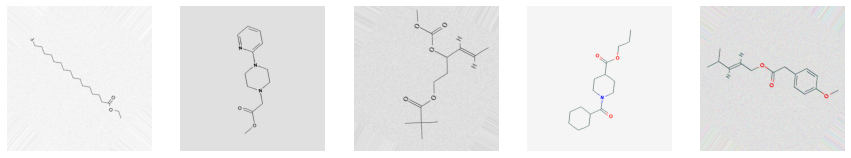

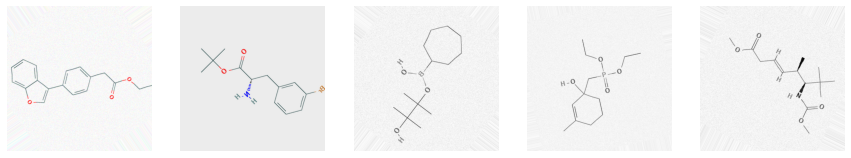

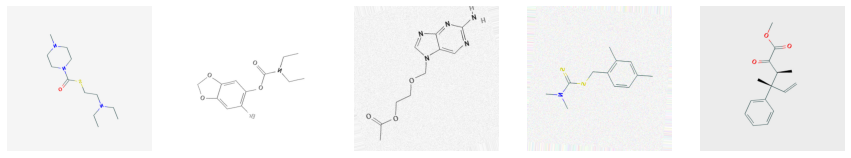

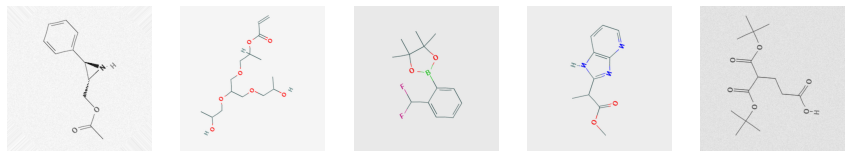

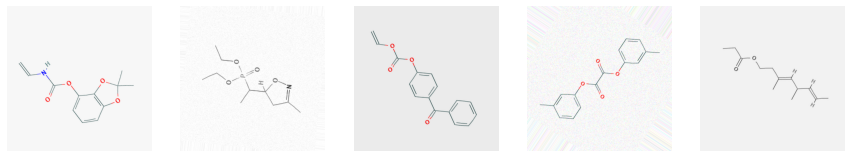

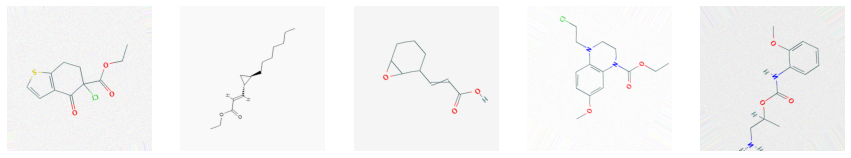

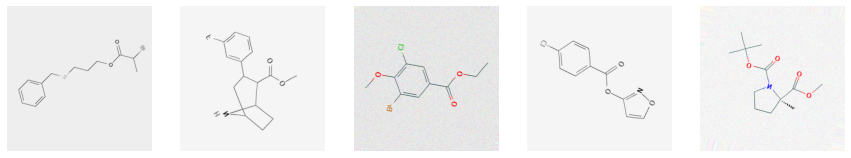

In [17]:
# Test parameter of ImageDataGenerator

for index, (img, label) in enumerate(dataset):
  plt.figure(figsize=(15, 15))
  for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow( np.clip(img[i], 0, 1) )
    plt.axis('off')
  plt.show()
  if index == 6:
    break

# Model Architecture

## EfficientNet-B3

In [18]:
import efficientnet.tfkeras as efn

pret_model = efn.EfficientNetB1(include_top = False, weights='noisy-student', input_shape=IMG_SHAPE)

pret_model.trainable = True

attention_features_shape = 10 * 10
features_shape = 1280

# Xception : [7, 7, 2048]
# InceptionResNetV2 : [5, 5, 1536]
# EfficientNetB0 : [7, 7, 2560]

In [19]:
pret_model.output.shape

TensorShape([None, 10, 10, 1280])

## CNN Encoder (Encoder output of feature extraction)

In [20]:
from tensorflow.keras.models import Sequential

def create_encoder():
  x = tf.keras.layers.Reshape(target_shape=(attention_features_shape, -1))(pret_model.input)
  
  x = tf.keras.layers.Dense(encoding_size)(x)
  output = tf.keras.layers.LeakyReLU()(x)
  return tf.keras.Model(pret_model.input, output)

In [21]:
encoder = create_encoder()

UnboundLocalError: local variable 'output' referenced before assignment

In [22]:
from tensorflow.keras.layers import BatchNormalization

for index, layer in enumerate(encoder.layers):
  if index <= 20 and not isinstance(layer, BatchNormalization):
    layer.trainable = True

In [23]:
# encoder.summary()

## Bahdanau Attention

In [24]:
from tensorflow.keras.layers import Dense, Embedding, GRU

In [25]:
def create_attention(features, hidden, method = 'dot'):
  # features(CNN_encoder output) shape == (batch_size, 25, embedding_dim)
  # hidden shape == (batch_size, 1, hidden_size)
  
  if method == 'concat':
    x = tf.concat((features, hidden), axis=1)
    attention_hidden_layer = tf.nn.tanh( Dense(units)(x) )

  elif method == 'general':
    features = Dense(units)(features)
    attention_hidden_layer = tf.matmul( features, hidden, transpose_b=True )

  elif method == 'dot': ## Embedding_size must equal to Units
    attention_hidden_layer = tf.matmul( features, hidden, transpose_b=True )
  
  score = Dense(1)(attention_hidden_layer)
  attention_weights = tf.nn.softmax(score, axis=1)

  context_vector = attention_weights * features
  context_vector = tf.reduce_sum(context_vector, axis=1)
  
  return context_vector, attention_weights


## Create RNN Decoder

In [26]:
def create_decoder():
  features = tf.keras.layers.Input((attention_features_shape, encoding_size))
  dec_input= tf.keras.layers.Input((1))
  hidden = tf.keras.layers.Input((units))
  
  # x shape after passing through embedding == (batch_size, 1, encoding_size) 
  embedd = Embedding(vocab_size, encoding_size)(dec_input)
  
  output, state = GRU(units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')(embedd, initial_state=[hidden])

  # context vector == (batch_size, hidden_size)
  context_vector, attention_weights = create_attention(features, output)
  
  # x shape after concatenation == (batch_size, 1, encoding_size + hidden_size)
  x = tf.concat([tf.expand_dims(context_vector, 1), output], axis = -1)

  # shape == (batch_size, max_length, hidden_size)
  x = Dense(units)(x)
  
  # x shape == (batch_size * max_length, hidden_size)
  x = tf.reshape(x, (-1, x.shape[2]))

  # output shape == (batch_size * max_length, vocab)
  x = Dense(vocab_size, activation='softmax')(x)

  return tf.keras.models.Model([features, dec_input, hidden], [x, state, attention_weights])

def reset_state(batch_size):
  return tf.zeros((batch_size, units))

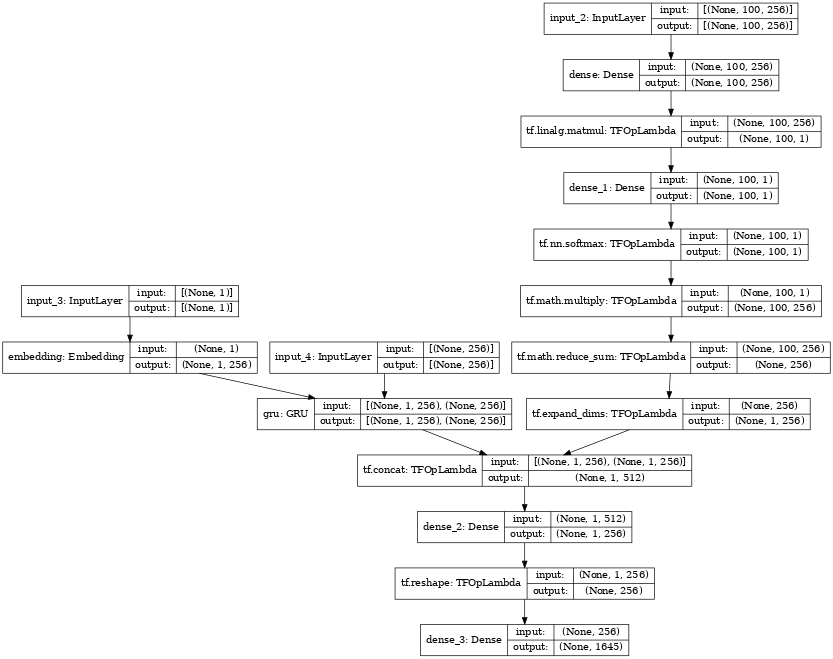

In [27]:
decoder = create_decoder()
tf.keras.utils.plot_model(decoder, to_file='model_luong.png', show_shapes=True, dpi = 49)

# Custom Loss Function


In [28]:
def loss_fn(real, pred):
  # Word Loss

  real_onehot = tf.one_hot(tf.cast(real, tf.uint8), vocab_size)

  loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction = 'none', label_smoothing=0.2)
  mask = tf.math.logical_not(tf.math.equal(real, tokenizer.word2index['<pad>'])) # make padding element -> true(1) -> false (0)
  loss_ = loss_object(real_onehot, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Metrics

# Accuracy

In [29]:
train_acc = tf.keras.metrics.Accuracy(name='train_accuracy')
val_acc = tf.keras.metrics.Accuracy(name='val_accuracy')

# Bleu

In [30]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class Bleu(tf.keras.metrics.Metric):
  def __init__(self, name='bleu', **kwargs):
    super(Bleu, self).__init__(name=name, **kwargs)
    self.score = self.add_weight(name='score', initializer='zeros')
    self.count = self.add_weight(name='count', initializer='zeros')
    self.chencherry = SmoothingFunction()

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = y_true[y_true != tokenizer.word2index['<pad>']]
    idx = np.where(y_pred == tokenizer.word2index['<end>'])[0]

    if idx != []:
      y_pred = y_pred[:idx[0]+1]
    
    values = sentence_bleu([y_true[1:]], y_pred, smoothing_function=self.chencherry.method4)

    self.count.assign_add(1)
    self.score.assign_add(values)

  def result(self):
    return self.score / self.count

  def reset_states(self):
    self.count.assign(0)
    self.score.assign(0)

# Callbacks

In [31]:
class EarlyStopping():
  def __init__(self, monitor = 'val_bleu', mode = 'max', patience = 1, encoder = encoder, decoder = decoder):
    if mode == 'max':
      self.mode = 'max'
      self.best = -100
    else: # Min
      self.mode = 'min'
      self.best = 100
    self.patience = patience
    self.wait = 0
    self.encoder = encoder
    self.decoder = decoder

  def callback(self, log, epoch):
    if self.mode == 'max':
      if log < self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} < best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save('Luong_model/Encoder_model.h5', include_optimizer=False)
        self.decoder.save('Luong_model/Decoder_model.h5', include_optimizer=False)
        print('Save Model Succesful')
    else: # 'min'
      if log > self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} > best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save('Luong_model/Encoder_model.h5', include_optimizer=False)
        self.decoder.save('Luong_model/Decoder_model.h5', include_optimizer=False)
        print('\tSave Model Succesful')
    
    return False

In [32]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', patience = 5)

# Training Model

In [33]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001, decay_steps = 10000, decay_rate=0.96, staircase=True, name=None
)
opt = tf.keras.optimizers.Adam(0.0001)

train_acc = tf.keras.metrics.Accuracy(name='train_accuracy')
val_acc = tf.keras.metrics.Accuracy(name='val_accuracy')
bleu = Bleu()
bleu_val = Bleu()

## Train Step

In [34]:
for i in range(5):
  print(i, tokenizer.index2word[i])

0 <pad>
1 <start>
2 <end>
3 <unk>
4 2


In [35]:
@tf.function
def train_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_train_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0 
  
  with tf.GradientTape() as tape:
    img_feature = encoder(img_tensor, training = True)

    for i in range(1, max_length_train):
      # passing the features through the decoder
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = True)
      loss += loss_fn(target[:,i], predictions)
      
      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_train_pred = tf.concat( [dec_train_pred, predict_ids], axis = -1 )
      
      # using teacher forcing
      decoder_input = tf.expand_dims(target[:, i], 1)
  
  # Metrics
  mask = tf.math.logical_not(tf.math.equal(target, tokenizer.word2index['<pad>']))
  mask = tf.cast(mask, tf.float32)
  train_acc.update_state(target, dec_train_pred, sample_weight = mask)

  gradient = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables) 
  opt.apply_gradients(zip(gradient, encoder.trainable_variables + decoder.trainable_variables))

  return {'pred': dec_train_pred, 'loss': loss / max_length_train}

## Test Step

In [36]:
@tf.function
def test_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_val_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0

  with tf.GradientTape() as tape:  
    img_feature = encoder(img_tensor, training = False)

    for i in range(1, max_length_test):
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = False)
      loss += loss_fn(target[:,i], predictions)

      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_val_pred = tf.concat( [dec_val_pred, predict_ids], axis = -1 )
        
      decoder_input = tf.expand_dims(target[:, i], 1)

      # Metrics
  mask = tf.math.logical_not(tf.math.equal(target, tokenizer.word2index['<pad>']))
  mask = tf.cast(mask, tf.float32)
  val_acc.update_state(target, dec_val_pred, sample_weight = mask)

  return {'pred': dec_val_pred, 'loss': loss/max_length_test}

In [37]:
loss_train_arr, loss_val_arr, acc_train_arr, acc_val_arr = [], [], [], []

def fit(epochs, num_steps, num_steps_val):
  divide_epoch = generator.samples//(num_steps*BATCH_SIZE)
  total_loss, total_loss_val = 0, 0
  for epoch in trange(1, epochs+1, colour='green', leave=False):
    for index, (image, caption) in tqdm(enumerate(dataset.take(num_steps)), total=num_steps, leave=False):
      monitor = train_step(image, caption)
      total_loss += monitor['loss'].numpy()
  
    for index, (image, caption) in tqdm(enumerate(dataset_val.take(num_steps_val)), total=num_steps_val, leave=False):
      monitor_val = test_step(image, caption)
      total_loss_val += monitor_val['loss']
    
    # total_loss /= num_steps
    # total_loss_val /= num_steps_val
    
    if epoch%divide_epoch != 0:
      loss_per_epoch = total_loss/(num_steps*(epoch%divide_epoch))
      val_loss_per_epoch = total_loss_val/(num_steps_val*(epoch%divide_epoch))
    else:
      loss_per_epoch = total_loss/(num_steps*divide_epoch)
      val_loss_per_epoch = total_loss_val/(num_steps_val*divide_epoch)

    loss_train_arr.append(loss_per_epoch)
    loss_val_arr.append(val_loss_per_epoch)
    acc_train_arr.append(train_acc.result().numpy())
    acc_val_arr.append(val_acc.result().numpy())

    print(f'Epoch {(epoch/divide_epoch):.1f}/{(epochs//divide_epoch)+1}: '\
          f'loss : {(loss_per_epoch):.4f} acc : {(train_acc.result().numpy()):.4f} '\
          f'val_loss : {(val_loss_per_epoch):.4f} val_acc : {(val_acc.result().numpy()):.4f}'
    )    

    if earlystop.callback(val_loss_per_epoch, epoch):
      break
    
    if epoch%divide_epoch == 0:
      train_acc.reset_states()
      val_acc.reset_states()
      total_loss, total_loss_val = 0, 0

    del monitor
    del monitor_val

## Fitting

In [44]:
fit(epochs = 70, num_steps = 1000, num_steps_val = 250)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

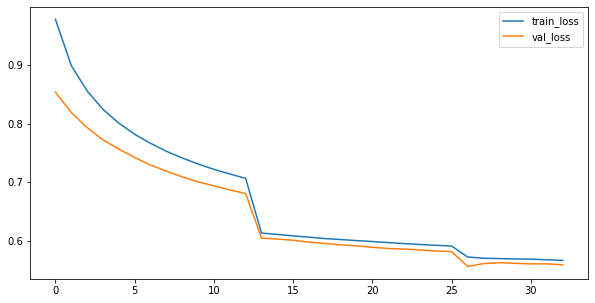

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(loss_train_arr, label='train_loss')
plt.plot(loss_val_arr, label='val_loss')
plt.legend()
plt.show()

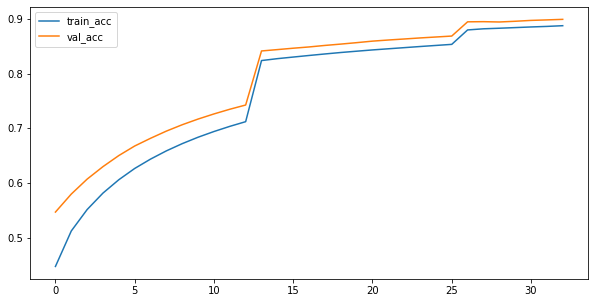

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(acc_train_arr, label='train_acc')
plt.plot(acc_val_arr, label='val_acc')
plt.legend()
plt.show()

# Load Best Model

In [30]:
# encoder.save('encoder_model.h5', include_optimizer=False)
# decoder.save('decoder_model.h5', include_optimizer=False)

encoder = tf.keras.models.load_model('Luong_model/Encoder_model.h5')
decoder = tf.keras.models.load_model('Luong_model/Decoder_model.h5')

# Caption It

In [37]:
from nami.AI.kme_tokenize import Segmentation
kme_segment = Segmentation()

In [38]:
def reset_state(batch_size):
  return tf.zeros((batch_size, units))
attention_features_shape = 100

In [39]:

def predict(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden_state = reset_state(batch_size = 1)

    image = tf.reshape(image, shape=(1,image.shape[0],image.shape[1],image.shape[2]))
    features = encoder( image, training=False )

    dec_input = tf.expand_dims([tokenizer.word2index['<start>']], 0)
    result, result_id = [], []

    for i in range(max_length): # *

        predictions, hidden_state, attention_weights = decoder([features, dec_input, hidden_state], training=False)

        attention_plot[i] = tf.reshape(attention_weights, (-1 )).numpy()

        predicted_id = np.argmax(predictions, axis=-1)[0]

        result.append(tokenizer.index2word[predicted_id])

        if tokenizer.index2word[predicted_id] == '<end>':
            return result_id, result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
        result_id.append(predicted_id)

    attention_plot = attention_plot[:len(result), :]
    return result_id, result, attention_plot

In [40]:
test_acc = tf.keras.metrics.Accuracy()

@tf.function
def evaluate(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_test_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  with tf.GradientTape() as tape:  
    img_feature = encoder(img_tensor, training = False)

    for i in range(1, max_length_test):
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = False)

      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_test_pred = tf.concat( [dec_test_pred, predict_ids], axis = -1 )
        
      decoder_input = tf.expand_dims(dec_test_pred[:, -1], 1)

      # Metrics
  mask = tf.math.logical_not(tf.math.equal(target, tokenizer.word2index['<pad>']))
  mask = tf.cast(mask, tf.float32)
  test_acc.update_state(target, dec_test_pred, sample_weight = mask)
  
  return dec_test_pred

In [41]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(''.join(result[:-1]), fontsize=20, y = 1.03)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot((len_result//3)+1, (len_result//3)+1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(np.clip(image, 0, 1))
        ax.imshow(temp_att, cmap='BuGn', alpha=0.7, extent=img.get_extent())
    
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [42]:
for img, label in tqdm(dataset_test.take(1300), total=1300):
  y_pred = evaluate(img, label)  

print( test_acc.result().numpy() )

  0%|          | 0/1300 [00:00<?, ?it/s]

0.08715022


In [43]:
image_test, sequences_test = list(dataset_test.take(10).as_numpy_iterator())[0]

100%|██████████| 1/1 [00:00<00:00, 4419.71it/s]
Real: methyl 3-bromo-4,5-dimethoxy-2-methylbenzoate
Pred: 6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S6S


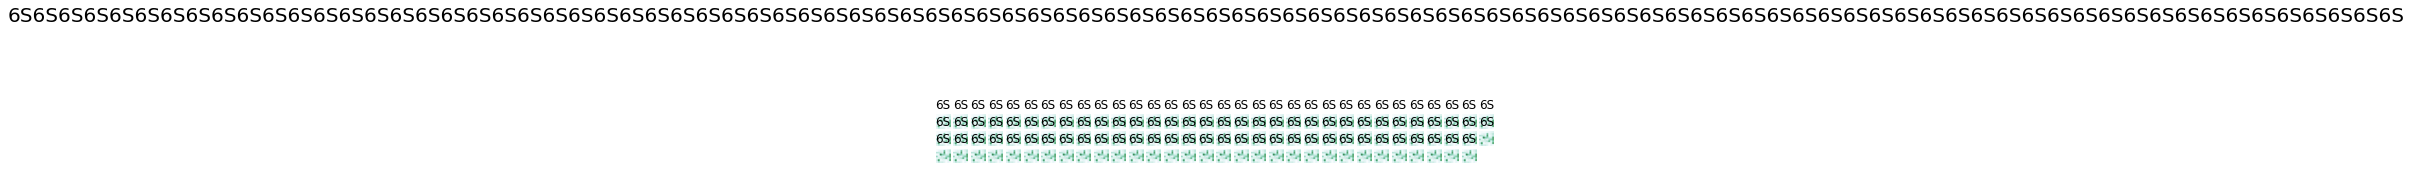

In [44]:
_, result, attention_plot = predict(image_test[10], max_length_test)

print('Real:', ''.join( tokenizer.sequences_to_text([sequences_test[10]])[0] ).replace('<start>', '').replace('<end>', '').replace('<pad>', ''))
print('Pred:', ''.join(result[:-1]))

plot_attention(image_test[10], result, attention_plot)